In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import datetime as dt
from datetime import datetime
from matplotlib.animation import FuncAnimation
import imageio

%matplotlib notebook

In [2]:
list_aqi = ['daily_aqi_by_cbsa_2002.csv', 'daily_aqi_by_cbsa_2003.csv', 
           'daily_aqi_by_cbsa_2004.csv', 'daily_aqi_by_cbsa_2005.csv', 
           'daily_aqi_by_cbsa_2006.csv', 'daily_aqi_by_cbsa_2007.csv', 
           'daily_aqi_by_cbsa_2008.csv', 'daily_aqi_by_cbsa_2009.csv', 
           'daily_aqi_by_cbsa_2010.csv', 'daily_aqi_by_cbsa_2011.csv', 
           'daily_aqi_by_cbsa_2012.csv', 'daily_aqi_by_cbsa_2013.csv', 
           'daily_aqi_by_cbsa_2014.csv', 'daily_aqi_by_cbsa_2015.csv', 
           'daily_aqi_by_cbsa_2016.csv', 'daily_aqi_by_cbsa_2017.csv', 
           'daily_aqi_by_cbsa_2018.csv', 'daily_aqi_by_cbsa_2019.csv', 
           'daily_aqi_by_cbsa_2020.csv', 'daily_aqi_by_cbsa_2021.csv']

aqi_columns = ['CBSA', 'Date', 'AQI', 'Category', 'Defining Parameter']

# Download all the AQI .csv files and keep only San Jose data: 

aqi = pd.DataFrame(data = None, columns = aqi_columns) # make an empty dataset to fill

for i in list_aqi:
    df = pd.read_csv(i)
    df = df[df['CBSA'] == 'San Jose-Sunnyvale-Santa Clara, CA'] # OR: Sacramento--Roseville--Arden-Arcade, CA
    df = df[['CBSA', 'Date', 'AQI', 'Category', 'Defining Parameter']]
    aqi = aqi.append(df)

aqi.reset_index()

# Clean dtypes (Date, AQI): 

aqi['Date'] = pd.to_datetime(aqi['Date'], format = '%Y-%m-%d')
aqi['AQI'] = pd.to_numeric(aqi['AQI'])


#aqi.index = aqi['Date']

In [3]:
## Add a column of 5-day simple rolling average for AQI: 


    # Add a column of monthly averages to AQI: 
#aqi = aqi.assign(mean_aqi = aqi.groupby(pd.Grouper(freq = 'M')).AQI.transform('mean'))

aqi['pandas_SMA_15'] = aqi.iloc[:,2].rolling(window = 15).mean()

aqi = aqi[['Date', 'CBSA', 'AQI', 'Category', 'Defining Parameter', 'pandas_SMA_15']]

# Add a year column: 
aqi['Year'] = aqi['Date'].dt.year

In [4]:
# Download all fire .csv's, 
# label close, medium, and far fires, 
# and append all to a single dataframe called "fire"
# Add a column "Distance" to categorize fires as close, medium, or far away from San Jose
 

list_fire = ['2002_fires.csv', '2003_fires.csv', '2004_fires.csv', 
             '2005_fires.csv', '2006_fires.csv', '2007_fires.csv', 
             '2008_fires.csv', '2009_fires.csv', '2010_fires.csv', 
             '2011_fires.csv', '2012_fires.csv', '2013_fires.csv',
             '2014_fires.csv', '2015_fires.csv', '2016_fires.csv', 
             '2017_fires.csv', '2018_fires.csv', '2019_fires.csv', 
             '2020_fires.csv', '2021_fires.csv']


fire = pd.DataFrame(None, columns = ["Name", "County", "Acres", "Start Date", "Contained Date"])

for i in list_fire: 
    fire_test = pd.read_csv(i)
    fire_test = fire_test[["Name", "County", "Acres", "Start Date", "Contained Date"]]
    fire_test = fire_test.dropna(subset = ['County'])
    fire_test['Close'] = fire_test['County'].str.contains(pat = 'Santa Clara|Alameda|Santa Cruz|San Mateo|San Francisco')
    fire_test['Medium'] = fire_test['County'].str.contains(pat = 'Marin|Sonoma|Napa|Yolo|Solano|Sacramento|Contra Costa|San Joaquin|Stanislaus|Merced|San Benito|Monterey')
    fire_test['Far'] = fire_test['County'].str.contains(pat = 'Mendocino|Lake|Colusa|Glenn|Sutter|Yuba|Butte|Sierra|Nevada|Placer|El Dorado|Amador|Calaveras|Alpine|Tuolumne|Mariposa|Madera|Fresno|Mono|Kings|Tulare|Inyo|Plumas|Lassen|Shasta|Trinity|Humboldt|Del Norte|Siskiyou|Modoc')
    fire_test['Year'] = i[0:4]
    fire_test['Start Date'] = fire_test['Start Date'].str.extract('(\w+\s\d+)')
    fire_test['Contained Date'] = fire_test['Contained Date'].str.extract('(\w+\s\d+)')
    fire = fire.append(fire_test)

        ## I subsetted by distance for a different project. This isn't used in this project except to filter out Southern CA fires.
Distance = []

for i in range(len(fire)):
    if fire.iloc[i]['Close'] == True:
        Distance.append('Close')
    elif fire.iloc[i]['Medium'] == True: 
        Distance.append("Medium")
    elif fire.iloc[i]['Far'] == True: 
        Distance.append('Far')
    else: 
        Distance.append(np.nan)
        
fire['Distance'] = Distance

# Keep only fires close, medium, and far (Northern California fires only)
fire = fire.dropna(subset = ['Distance'])
fire.head()

,Name,County,Acres,Start Date,Contained Date,Close,Medium,Far,Year,Distance
2,Nicholas,Madera,"12,000",March 16,March 16,False,False,True,2002,Far
7,Ahlem,Merced,"6,000",May 23,May 23,False,True,False,2002,Medium
11,Skyway,Butte,"2,000",June 8,June 9,False,False,True,2002,Far
13,Forks,Siskiyou,"1,400",June 12,June 15,False,False,True,2002,Far
18,Vieux,Alameda,"1,029",June 18,June 18,True,False,False,2002,Close


In [5]:
## Clean the data type: 
fire['Acres'] = pd.to_numeric(fire['Acres'].str.replace(',', ''))
fire['Start Date'] = fire['Start Date'] + " " + fire['Year']
fire['Contained Date'] = fire['Contained Date'] + " " + fire['Year']
fire['Start Date']= pd.to_datetime(fire['Start Date'], format = '%B %d %Y')
fire['Contained Date'] = pd.to_datetime(fire['Contained Date'], format = '%B %d %Y')

fire = fire[['Start Date', 'Contained Date', 'Name', 'County', 'Acres', 'Distance']]
fire.head()


,Start Date,Contained Date,Name,County,Acres,Distance
2,2002-03-16,2002-03-16,Nicholas,Madera,12000,Far
7,2002-05-23,2002-05-23,Ahlem,Merced,6000,Medium
11,2002-06-08,2002-06-09,Skyway,Butte,2000,Far
13,2002-06-12,2002-06-15,Forks,Siskiyou,1400,Far
18,2002-06-18,2002-06-18,Vieux,Alameda,1029,Close


In [6]:
# If fire contained same day it started, add one to contained date to make it appear on graph:

End_Date = []
for i in range(fire.shape[0]):
    if fire.iloc[i]['Start Date'] == fire.iloc[i]['Contained Date']:
        End_Date.append(fire.iloc[i]['Contained Date']+ dt.timedelta(days = 1))
    else: 
        End_Date.append(fire.iloc[i]['Contained Date'])
End_Date

fire['End_Date'] = End_Date

fire['Year'] = fire['Start Date'].dt.year

fire.head()
    

,Start Date,Contained Date,Name,County,Acres,Distance,End_Date,Year
2,2002-03-16,2002-03-16,Nicholas,Madera,12000,Far,2002-03-17,2002
7,2002-05-23,2002-05-23,Ahlem,Merced,6000,Medium,2002-05-24,2002
11,2002-06-08,2002-06-09,Skyway,Butte,2000,Far,2002-06-09,2002
13,2002-06-12,2002-06-15,Forks,Siskiyou,1400,Far,2002-06-15,2002
18,2002-06-18,2002-06-18,Vieux,Alameda,1029,Close,2002-06-19,2002


In [7]:
# Extract start months and end months: 

start_month = []
end_month = []

for i in range(len(fire)): 
    month1 = fire.iloc[i]['Start Date'].month
    start_month.append(month1)
    month2 = fire.iloc[i]['End_Date'].month
    end_month.append(month2)

fire['Start_Month'] = start_month
fire['End_Month'] = end_month

start_day = []
end_day = []

for i in range(len(fire)): 
    day1 = fire.iloc[i]['Start Date'].day
    start_day.append(day1)
    day2 = fire.iloc[i]['End_Date'].day
    end_day.append(day2)
    
fire['Start_Day'] = start_day
fire['End_Day'] = end_day

fire['Start_MD'] = fire['Start_Month'] +0.01*fire['Start_Day']
fire['End_MD'] = fire['End_Month'] + 0.01*fire['End_Day']

fire.head()

,Start Date,Contained Date,Name,County,Acres,Distance,End_Date,Year,Start_Month,End_Month,Start_Day,End_Day,Start_MD,End_MD
2,2002-03-16,2002-03-16,Nicholas,Madera,12000,Far,2002-03-17,2002,3,3.0,16,17.0,3.16,3.17
7,2002-05-23,2002-05-23,Ahlem,Merced,6000,Medium,2002-05-24,2002,5,5.0,23,24.0,5.23,5.24
11,2002-06-08,2002-06-09,Skyway,Butte,2000,Far,2002-06-09,2002,6,6.0,8,9.0,6.08,6.09
13,2002-06-12,2002-06-15,Forks,Siskiyou,1400,Far,2002-06-15,2002,6,6.0,12,15.0,6.12,6.15
18,2002-06-18,2002-06-18,Vieux,Alameda,1029,Close,2002-06-19,2002,6,6.0,18,19.0,6.18,6.19


In [8]:
new_End_Date = []

for i in range(len(fire)):
    if fire.iloc[i]['End_MD'] < fire.iloc[i]['Start_MD']:
        new_End_Date.append(12.31)
    else:
        new_End_Date.append(fire.iloc[i]['End_Date'])

fire['new_End_Date'] = new_End_Date


# Manually enter two missing values based on research: 

fire.loc[fire.Name == 'Blue 2 Complex', 'End_Date'] = pd.to_datetime('2008-09-30')

fire.loc[fire.Name == 'SQF Complex','End_Date'] = pd.to_datetime('2020-12-31')


# Check: 
fire[fire['End_Date'] != fire['new_End_Date']]



,Start Date,Contained Date,Name,County,Acres,Distance,End_Date,Year,Start_Month,End_Month,Start_Day,End_Day,Start_MD,End_MD,new_End_Date
24,2008-06-20,NaT,Blue 2 Complex,Siskiyou,82186,Far,2008-09-30,2008,6,NaN,20,NaN,6.20,NaN,NaT
49,2020-08-19,2020-01-05,SQF Complex,Tulare,174178,Far,2020-12-31,2020,8,1.0,19,5.0,8.19,1.05,12.31
21,2021-07-22,NaT,Fly,Plumas,4300,Far,NaT,2021,7,NaN,22,NaN,7.22,NaN,NaT


In [9]:
## TRY ANIMATION: 

<IPython.core.display.Javascript object>


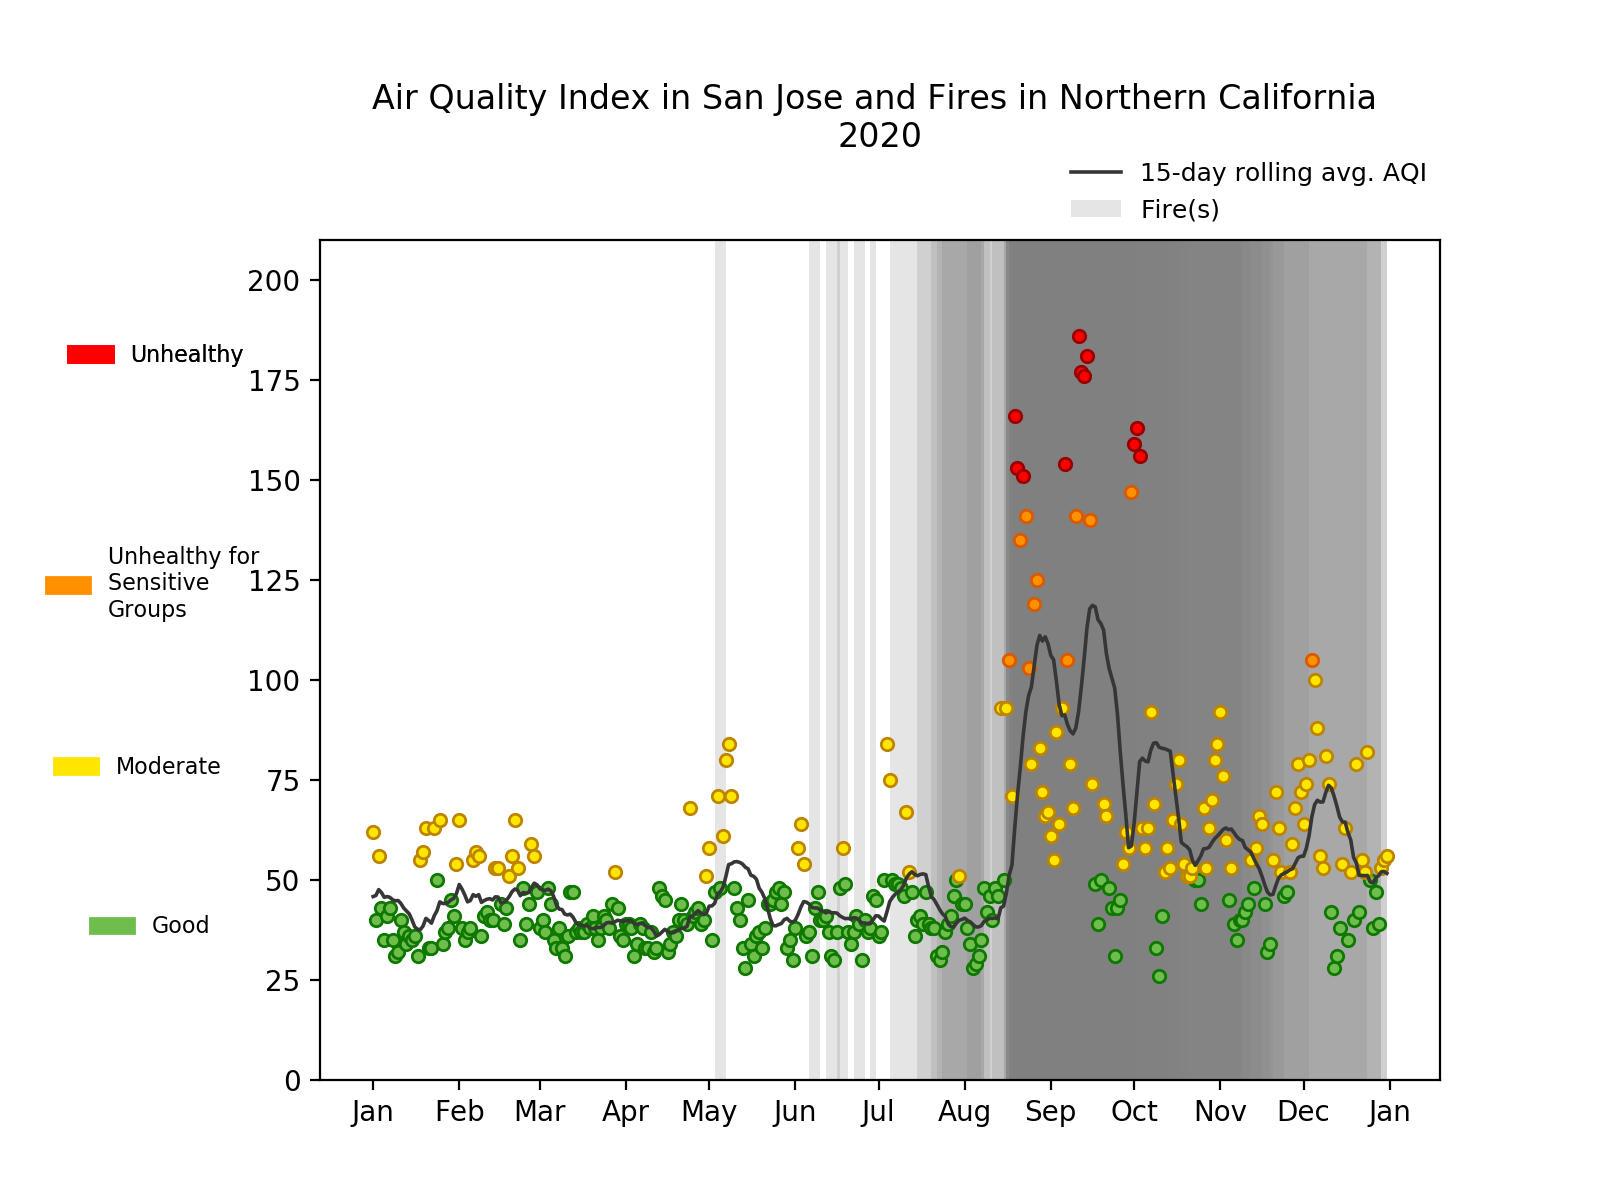

In [34]:
import matplotlib.patches as mpatches

# make a list of aqi and fire df's for each year: 
aqi_2002 = aqi[aqi['Year'] == 2002]
aqi_2003 = aqi[aqi['Year'] == 2003]
aqi_2004 = aqi[aqi['Year'] == 2004]
aqi_2005 = aqi[aqi['Year'] == 2005]
aqi_2006 = aqi[aqi['Year'] == 2006]
aqi_2007 = aqi[aqi['Year'] == 2007]
aqi_2008 = aqi[aqi['Year'] == 2008]
aqi_2009 = aqi[aqi['Year'] == 2009]
aqi_2010 = aqi[aqi['Year'] == 2010]
aqi_2011 = aqi[aqi['Year'] == 2011]
aqi_2012 = aqi[aqi['Year'] == 2012]
aqi_2013 = aqi[aqi['Year'] == 2013]
aqi_2014 = aqi[aqi['Year'] == 2014]
aqi_2015 = aqi[aqi['Year'] == 2015]
aqi_2016 = aqi[aqi['Year'] == 2016]
aqi_2017 = aqi[aqi['Year'] == 2017]
aqi_2018 = aqi[aqi['Year'] == 2018]
aqi_2019 = aqi[aqi['Year'] == 2019]
aqi_2020 = aqi[aqi['Year'] == 2020]

fire_2002 = fire[fire['Year'] == 2002]
fire_2003 = fire[fire['Year'] == 2003]
fire_2004 = fire[fire['Year'] == 2004]
fire_2005 = fire[fire['Year'] == 2005]
fire_2006 = fire[fire['Year'] == 2006]
fire_2007 = fire[fire['Year'] == 2007]
fire_2008 = fire[fire['Year'] == 2008]
fire_2009 = fire[fire['Year'] == 2009]
fire_2010 = fire[fire['Year'] == 2010]
fire_2011 = fire[fire['Year'] == 2011]
fire_2012 = fire[fire['Year'] == 2012]
fire_2013 = fire[fire['Year'] == 2013]
fire_2014 = fire[fire['Year'] == 2014]
fire_2015 = fire[fire['Year'] == 2015]
fire_2016 = fire[fire['Year'] == 2016]
fire_2017 = fire[fire['Year'] == 2017]
fire_2018 = fire[fire['Year'] == 2018]
fire_2019 = fire[fire['Year'] == 2019]
fire_2020 = fire[fire['Year'] == 2020]

list_aqi = [aqi_2002, aqi_2003, aqi_2004, aqi_2005, aqi_2006, aqi_2007, aqi_2008, aqi_2009, aqi_2010,
           aqi_2011, aqi_2012, aqi_2013, aqi_2014, aqi_2015, aqi_2016, aqi_2017, aqi_2018, aqi_2019, 
            aqi_2020]
list_fire = [fire_2002, fire_2003, fire_2004, fire_2005, fire_2006, fire_2007, fire_2008, fire_2009, 
            fire_2010, fire_2011, fire_2012, fire_2013, fire_2014, fire_2015, fire_2016, fire_2017, 
            fire_2018, fire_2019, fire_2020]

# Set up file names to save: 
filenames = []

# Set up the figure: 
fig = plt.figure(figsize = (8,6))
    # Add more whitespace around the figure for room for labels:
plt.subplots_adjust(left=0.2, bottom=0.1, right=0.9, top=0.8)

# Make the X-axis show the months: 
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)

# Create handles, labels for AQI color legend:
good = mpatches.Patch(color = '#6fbd4d', label = 'Good')
moderate = mpatches.Patch(color = '#ffe600', label = 'Moderate')
unhealthy_sens = mpatches.Patch(color = '#ff9100', label = 'Unhealthy for \nSensitive \nGroups')
unhealthy = mpatches.Patch(color = '#ff0000', label = 'Unhealthy')

# Color palette for scatterplot from AQI health cutoffs: 
colors = {'Good':'#6fbd4d', "Moderate":'#ffe600', 'Unhealthy for Sensitive Groups': '#ff9100', 'Unhealthy':'#ff0000'}
edge_colors = {'Good':'#0e7800', "Moderate":'#bd8400', 'Unhealthy for Sensitive Groups': '#d95a00', 'Unhealthy':'#960000'}

# Create the animation function: 
def update():
    for i in range(len(list_aqi)):
    
        plt.cla()

            # Set y-axis to be the same for all plots:
        plt.ylim(0,210)
            # Make the X-axis show the months: 
        locator = mdates.MonthLocator()
        fmt = mdates.DateFormatter('%b')
        plt.gca().xaxis.set_major_locator(locator)
        plt.gca().xaxis.set_major_formatter(fmt)
            # Plot the rolling average AQI: 
        plt.plot(list_aqi[i]['Date'], list_aqi[i]['pandas_SMA_15'], '-', color = '#363636', alpha = 1, label = '15-Day Rolling Average AQI', linewidth = 1.3, zorder = 3)
            # Plot the scatterplot of daily AQI, grouped and colored by health category: 
        grouped = list_aqi[i].groupby('Category')
        for key, group in grouped: 
            group.plot(ax = plt.gca(), kind = 'scatter', x = 'Date', y = 'AQI', color = colors[key], edgecolor = edge_colors[key], zorder = 2)
            # Plot fires: 
        xmins_all = np.array(list_fire[i]['Start Date'])
        xmaxs_all = np.array(list_fire[i]['End_Date'])
        for j in range(list_fire[i].shape[0]-1):
            plt.gca().axvspan(xmins_all[j], xmaxs_all[j], facecolor = 'gray', alpha = 0.2, zorder = 1)

            # Add label for year: 
        year = list_aqi[i].iloc[0]['Year']
        plt.title("Air Quality Index in San Jose and Fires in Northern California \n{}\n\n".format(year), loc = 'center')
        plt.ylabel("")
            # Add labels manually: 
        legend1 = plt.legend(["15-day rolling avg. AQI", "Fire(s)"], loc = 'upper left', fontsize = 9, bbox_to_anchor = (0.65, 1.12), frameon = False)
        legend2 = plt.legend(handles = [good], fontsize = 8, loc = 'left', bbox_to_anchor=(-0.08, 0.22), frameon = False)
        legend3 = plt.legend(handles = [moderate], fontsize = 8, loc = 'left', bbox_to_anchor = (-0.07, 0.41), frameon = False)
        legend4 = plt.legend(handles = [unhealthy_sens], fontsize = 8, loc = 'left', bbox_to_anchor = (-0.03, .66), frameon = False)
        legend5 = plt.legend(handles = [unhealthy], fontsize = 8, loc = 'left', bbox_to_anchor = (-0.05, 0.9), frameon = False)
            # Plot the labels:
        plt.gca().add_artist(legend1)
        plt.gca().add_artist(legend2)
        plt.gca().add_artist(legend3)
        plt.gca().add_artist(legend4)
        plt.gca().add_artist(legend5)

        plt.gca().get_xaxis().set_label_text("")

            # Name each year differnetly adn save as a png:
        filename = 'San Jose{}.png'.format(year)
            # append each png to the list of file names several times
            # multiple times makes for slower transition between years (more frames)
        filenames.append(filename)
        filenames.append(filename)
        filenames.append(filename)
        filenames.append(filename)
        filenames.append(filename)
        filenames.append(filename)
        filenames.append(filename)
        filenames.append(filename)
        filenames.append(filename)
        filenames.append(filename)
        plt.savefig(filename)


In [35]:
update()

/Users/sallycochrane/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: MatplotlibDeprecationWarning: Unrecognized location 'left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
/Users/sallycochrane/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Unrecognized location 'left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
/Users/sallycochrane/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: MatplotlibDeprecationWarning: Unrecognized location 'left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	l

/Users/sallycochrane/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: MatplotlibDeprecationWarning: Unrecognized location 'left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
/Users/sallycochrane/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Unrecognized location 'left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
/Users/sallycochrane/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: MatplotlibDeprecationWarning: Unrecognized location 'left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	l

/Users/sallycochrane/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: MatplotlibDeprecationWarning: Unrecognized location 'left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
/Users/sallycochrane/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: MatplotlibDeprecationWarning: Unrecognized location 'left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
/Users/sallycochrane/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Unrecognized location 'left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	l

/Users/sallycochrane/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: MatplotlibDeprecationWarning: Unrecognized location 'left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
/Users/sallycochrane/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Unrecognized location 'left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
/Users/sallycochrane/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: MatplotlibDeprecationWarning: Unrecognized location 'left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	l

In [36]:
filenames

['San Jose2002.png',
 'San Jose2002.png',
 'San Jose2002.png',
 'San Jose2002.png',
 'San Jose2002.png',
 'San Jose2002.png',
 'San Jose2002.png',
 'San Jose2002.png',
 'San Jose2002.png',
 'San Jose2002.png',
 'San Jose2003.png',
 'San Jose2003.png',
 'San Jose2003.png',
 'San Jose2003.png',
 'San Jose2003.png',
 'San Jose2003.png',
 'San Jose2003.png',
 'San Jose2003.png',
 'San Jose2003.png',
 'San Jose2003.png',
 'San Jose2004.png',
 'San Jose2004.png',
 'San Jose2004.png',
 'San Jose2004.png',
 'San Jose2004.png',
 'San Jose2004.png',
 'San Jose2004.png',
 'San Jose2004.png',
 'San Jose2004.png',
 'San Jose2004.png',
 'San Jose2005.png',
 'San Jose2005.png',
 'San Jose2005.png',
 'San Jose2005.png',
 'San Jose2005.png',
 'San Jose2005.png',
 'San Jose2005.png',
 'San Jose2005.png',
 'San Jose2005.png',
 'San Jose2005.png',
 'San Jose2006.png',
 'San Jose2006.png',
 'San Jose2006.png',
 'San Jose2006.png',
 'San Jose2006.png',
 'San Jose2006.png',
 'San Jose2006.png',
 'San Jose200

In [33]:
with imageio.get_writer('SanJose.gif', mode = 'I') as writer:
    for filename in filenames: 
        image = imageio.imread(filename)
        writer.append_data(image)